In [2]:
from brian2 import*
import matplotlib.pyplot as plt

**The simplest Synapse**
<br>
Two neurons, one spiking the other not. If no synapse the second neuron doesn't change. If we add a synape that stimulate the second neuron, then both are not constant.

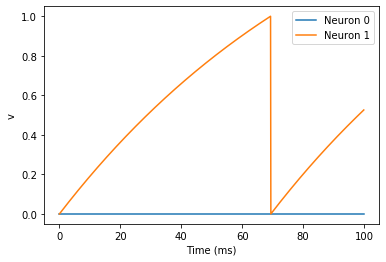

In [30]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [0,2]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

**Adding a weight**


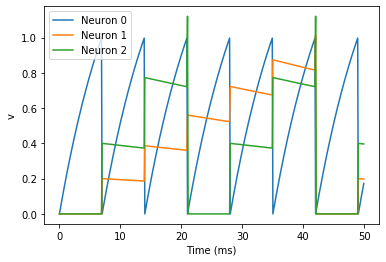

In [31]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

**Introducing a delay**

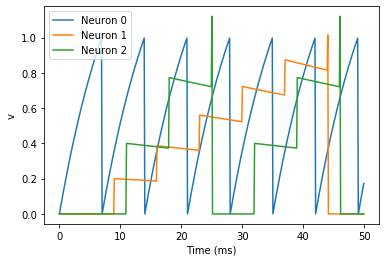

In [27]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

**More complex connectivity**

In [36]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

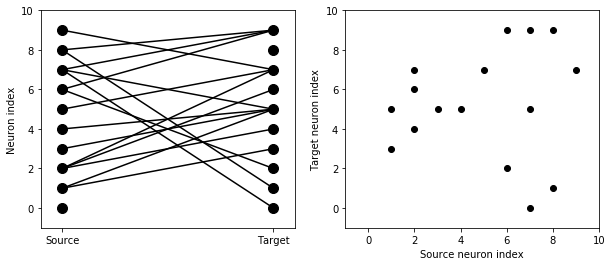

In [37]:


def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

Connecting with probability p

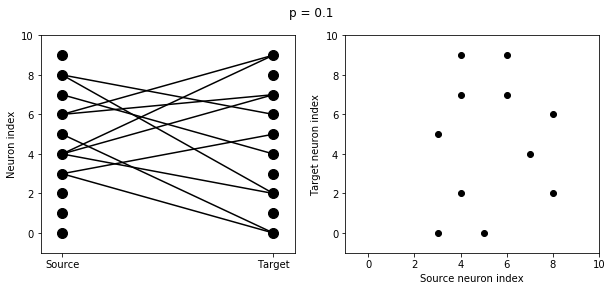

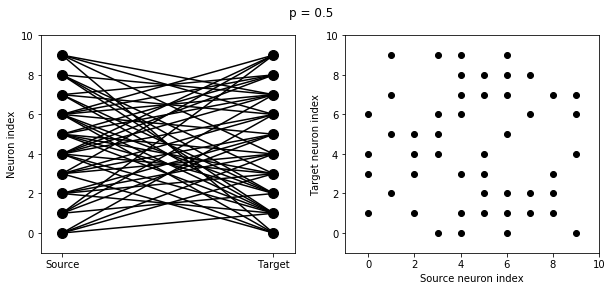

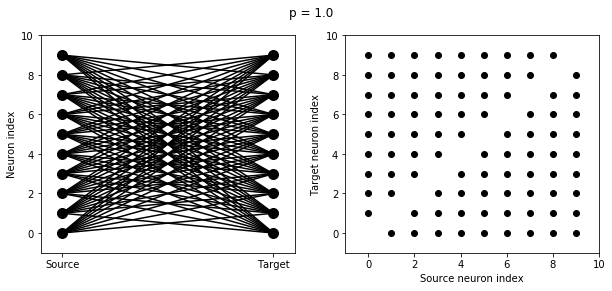

In [38]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

Connecting neighbours

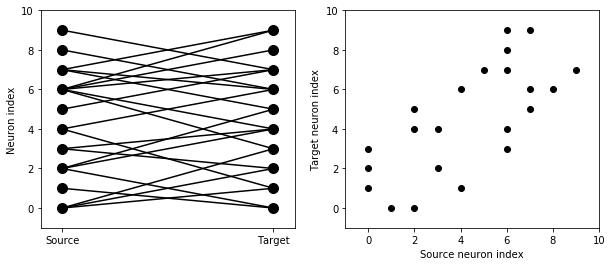

In [45]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j',p=0.5)
visualise_connectivity(S)

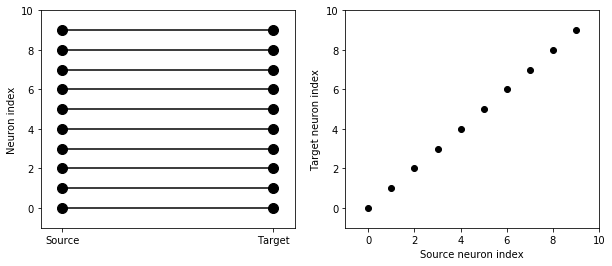

In [57]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='i==j',p=1)
visualise_connectivity(S)

**Adjusting weights**

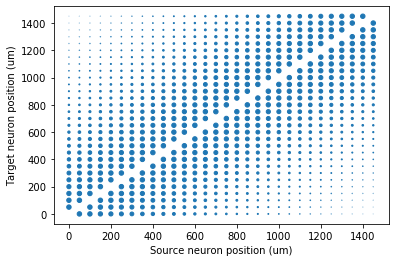

In [58]:
start_scope()

N = 30
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

More complex synapse models: STDP

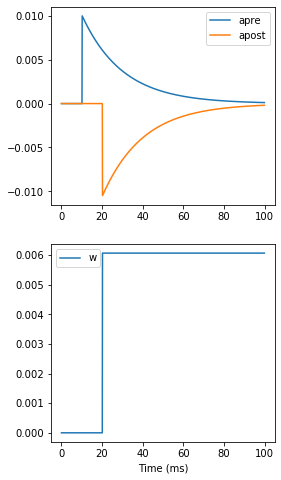

In [32]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')

S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(100*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

WARNING    Cannot use Cython, a test compilation failed: command 'cl.exe' failed: No such file or directory (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


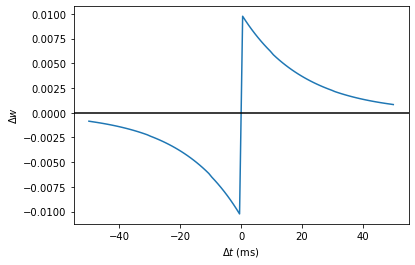

In [3]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');